In [47]:
%pylab inline
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')

Populating the interactive namespace from numpy and matplotlib


/home/vagrant/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rc', 'margins']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Introduction

We can model elections as distributions of ballots, where a ballot is a vector of choices:

$$\vec{b} = (\it{s_1}, \it{s_2}\dots \it{s_n})$$

For example, a ballot showing a vote for the candidate in the first position in a two choice, vote-for-one contest  might look like $(1, 0)$. Defining a ballot this way gives us flexibility to support many social choice functions, e.g. for RCV the "votes" could be rankings. However, in this example we will only examine a two-candidate, first-past-the-post contest

Note that this isn't the only way to define a ballot. Methods like SHANGRLA assign an integer to various kinds of votes, for example. 

An election is then a distrubition of ballots. For simplicity, we will examine a contest with no invalid votes, i.e. no undervotes or overvotes. This allos us to shorten our notation for ballot by treating a vote for the first candidate as a 1 and a vote for the loser as a 0. If the contest has 10 ballots and the first candidate won with 6 votes, one possible distribution of ballots could be 

$$\vec{e} = [0, 1, 1, 0, 0, 1, 1, 1, 1, 0]$$

This particular election has $10 \choose 6$ different possible distributions of votes. In general, there are $2^{n}$ possible elections. For ten ballots, that's $2^{10} = 1,024$ possible elections. We can plot the distributions of their margins:

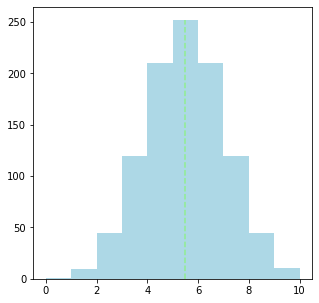

In [48]:
n = 10
margins = np.zeros(2**n)
for i in range(2**n):
    margins[i] = (np.sum([int(j) for j in list('{0:0b}'.format(i))]))

fig, ax = plt.subplots(figsize=(5,5))
counts, bins, _ = ax.hist(margins, color='lightblue')
ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))


Perhaps unsurprisingly, this looks a lot like a uniform distribution with a mean centered around a tie. This means that were we to sample an election at random without knowing anything about it, it would be more likely a tie than have a wide margin. 

If we desire to audit an election, as we sample more and more ballots, the space of possible elections shrinks. Essentially, for $m$ ballots that are sampled, there are $2^{n - m}$ possible elections remaining. For example, imagine we sample two ballots from our example eletion and both are votes for the winner. The distribution of _possible remaining_ elections looks different!

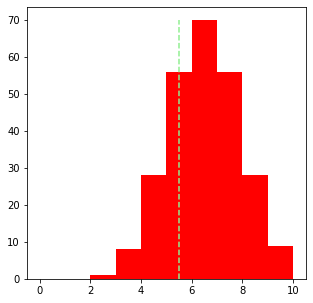

In [49]:
m = 2
audited_margins = np.zeros(2**(n - m))
for i in range(2**(n - m)):    
    audited_margins[i] = 2 + (np.sum([int(j) for j in list('{0:0b}'.format(i))])) # Add two votes for the "winner"
ax.cla()
counts, bins, _ = ax.hist(audited_margins, range=(0, n), color='red')
ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
fig

To more clearly demonstrate this, let's plot these two distributions on top of each other. The audited distribution is in red: 

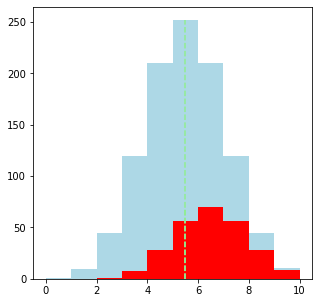

In [50]:
counts, _, _ = ax.hist(margins, color='lightblue')
_ = ax.hist(audited_margins, range=(0, n), color='red')
ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
fig

It's shifted to the right, and it's a lot smaller! Think about what this is telling us: based on our sample, the total possible elections has dramatically decreased. Moreover, the mean of the audited distribution has moved to the right, because it is _more likely_ that the winner won, given that we have already found two ballots for them. As we sample more, the distribution shrinks and moves more. Let's say that we sample two more ballots, and one is for the winner and one is for the loser.  

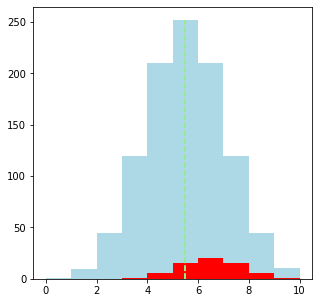

In [51]:
m = 4
audited_margins = np.zeros(2**(n - m))

for i in range(2**(n - m)):    
    audited_margins[i] = (m - 1) + (np.sum([int(j) for j in list('{0:0b}'.format(i))])) # Add two votes for the "winner"

counts, _, _ = ax.hist(margins, color='lightblue')
_ = ax.hist(audited_margins, range=(0, n), color='red')


ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
fig

Things are getting difficult to make out as our distribution shrinks. Rather than continue on with absolute counts, let's normalize our histograms. Now, rather than representing counts, they show the proportion of possible elections each margin takes up. These are probabilities!

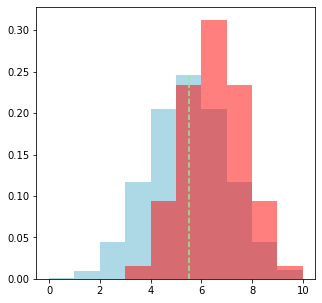

In [52]:
ax.cla()
counts, _, _ = ax.hist(margins, density=True, color='lightblue')
_ = ax.hist(audited_margins, range=(0, n), color='red', alpha=0.5,  density=True)


ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
fig

Whoa! Our audited distribution is taller than our unaudited distribution now! Because both of these distributions are showing proportions, their areas both sum to the same thing. Because our audited distribution has fewer possible bins (there are $2^n - 2^{n - m} fewer options), the area had to go somewhere. This can be thought of as the audit becoming "more confident" in the election outcome: the more ballots we look at, the more we know about what the true distribution of ballots is, and we rule out certain distributions by default. 

Another point of note: since our graphs are now probabilities, we can start to express a level of confidence about the election result. In the context of our example here, the first candidate "wins" if the margin is greater than 5, because that means they have more votes than the loser. If we want to be 90% sure that that candidate won, we need to sample ballots until 90% of the area of the distribution above is to the right of a vertical line drawn at 6. 

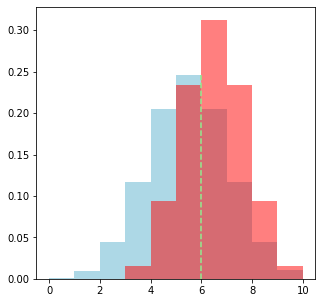

In [53]:
ax.cla()
counts, _, _ = ax.hist(margins, color='lightblue', density=True)
_ = ax.hist(audited_margins, range=(0, n), color='red', alpha=0.5,  density=True)

ax.vlines(6, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
fig

So how do we find the areas here? If we know the proportions of the counts of margins for all elections, in this example we can just add them up where applicable. Because each election is represented as a "unit" square in our diagram, adding them together produces an area that is the count of the elections selected by our criteria. So to get our confidence level, we just find all elections where the margin was less than 6 in our example, and divide that by the total number of possible elections, $2^{n - m}$.

In [54]:
counts, _ = np.histogram(audited_margins)
greater_than_5 = sum(counts[5:])

print('confidence: {:2.2f}%'.format(100*greater_than_5/2**(n- m)))


confidence: 65.62%


We're already pretty sure that the winner really won! If we audit two more ballots, and they are votes for the winner: 

confidence: 93.75%


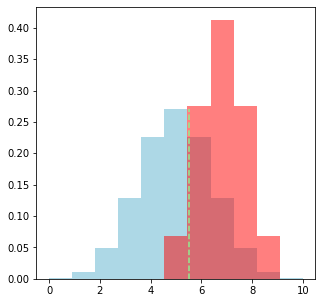

In [55]:
m = 6
audited_margins = np.zeros(2**(n - m))
ax.cla()

for i in range(2**(n - m)):    
    audited_margins[i] = (m - 1) + (np.sum([int(j) for j in list('{0:0b}'.format(i))])) # Add four votes for the "winner"

counts, bins, _ = ax.hist(margins, bins=11, color='lightblue', density=True)

_ = ax.hist(audited_margins, bins=11, range=(0, n), color='red', alpha=0.5,  density=True)


ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
counts, _ = np.histogram(audited_margins, range=(0, 11))
greater_than_5 = sum(counts[5:])
print('confidence: {:2.2f}%'.format(100*greater_than_5/2**(n- m)))
fig

Great! We've successsfully done an audit. So long as we're always willing to sample ballots until we either run 
out of ballots or our confidence level is sufficiently high, this audit could even be considered risk limiting. Showing the process: 


In [62]:
ax.cla()

def draw_dist(m):
    ax.cla()
    n = 10
    print(m, n-m)

    audited_margins = np.zeros(2**(n - m))
    for i in range(2**(n - m)):    
        audited_margins[i] = m +(np.sum([int(j) for j in list('{0:0b}'.format(i))])) # Add four votes for the "winner"

#     counts, bins, patch = 
    _, _, patches = ax.hist(audited_margins, range=(0, 11), density=True, color='red', alpha=0.5)

    ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))
    ax.set_ylim(0,1.0)
    return ax, 

def update(i):
    draw_dist(i)

anim = FuncAnimation(fig, update, frames=11, interval=1000)
anim.save('media/permutation_audit.gif', writer='imagemagick',  fps=1)


0 10
0 10
1 9
2 8
3 7
4 6
5 5
6 4
7 3
8 2
9 1
10 0


In [63]:
Image(url='media/permutation_audit.gif')

Unfortunately, there's a catch. We've only been looking at a really small election. With only ten ballots, there were already 1024 different possible permutations of elections. Since this is an exponential function, by the time we look at elections of practical size, from several hundred to millions of ballots, permutations will be impossible to use, since the number of possible elections will surpass the number of atoms in the universe! So we need another way to perform the kind of test outlined here. To do so, we will use the distributions we've discussed here to inform a less exact but much more feasile approach using statistics. 